# Surrogate model of a dynamical system by neural network
State variables: $\theta$(angular position) , $\dot{\theta}$(angular velocity) 
 
    Input: torque(u)
 
   Output: Cos(theta), sin(theta), thta_dot

Dynamics : 

  $D=m*L*L$ 
  
  $d\theta/dt=\dot{\theta}$ 
  
  $d\dot{\theta}/dt=(1/D)*(-m*g*L*Sin(\theta) - b*\dot{\theta}) +(1/D)*u $
  
parameters: 
 mass of ball(m)
 length of string(L)
 drag(b)
 

Data collection process: random sample from action space(input space) of dynamical system  and observe output of those imputs and collect multiple trajectories. In this case, we collected 20 trajectory of 1000 steps in each trajectory.

Dynamics system simultor: OpenAI gym (easy to collect) 

In [14]:
from torch.optim import Adam
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
HIDDEN1_UNITS=256
HIDDEN2_UNITS=128
HIDDEN3_UNITS=64
HIDDEN4_UNITS=32

class cnn():
    def __init__(self, data_file,state_size=4,action_size=3,Testing=False):
     self.testing=Testing
     self.data= pd.read_csv(data_file)
     self.data['action']=(self.data['action']+2)/4
     self.data['cos_theta_old']=(self.data['cos_theta_old']+1)/2
     self.data['cos_theta']=(self.data['cos_theta']+1)/2
     self.data['sin_theta']=(self.data['sin_theta']+1)/2
     self.data['sin_theta_old']=(self.data['sin_theta_old']+1)/2
     self.data['theta_dot']=(self.data['theta_dot']+8)/16
     self.data['theta_dot_old']=(self.data['theta_dot_old']+8)/16
     #print('data is:',self.data)
     self.model = Net(state_size, action_size).float()
     self.optim = Adam(self.model.parameters(), lr=0.03)
     self.criterion= nn.MSELoss()
     
    def train(self,epoch) :
     batch_size=32
     data_len=self.data.shape[0]
     print('Size of data:',data_len)
     loss_track=[]
     running_loss = 0.0
     x=self.data[['action',"cos_theta_old","sin_theta_old","theta_dot_old"]].values
     y=self.data[["cos_theta","sin_theta","theta_dot"]].values
     for epo in range(epoch):
       for i in range(int(data_len)):
        rand_ids = np.random.randint(0, data_len, batch_size)
        #print("ids are ",rand_ids)
        self.optim.zero_grad()
        inputs, labels = x[rand_ids],y[rand_ids]
        #print("Inputs are:",inputs)
        #print("labels are:",labels)
        inputs=torch.from_numpy(inputs)
        labels=torch.from_numpy(labels).float()
        #print("type of imput",type(inputs))
        
        # forward + backward + optimize
        outputs = self.model(inputs.float())
        loss = self.criterion(outputs, labels)
        #print('loss is:',loss)
        loss.backward()
        self.optim.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %(epo + 1, i + 1, running_loss))
            loss_track.append(running_loss)
            running_loss = 0.0
     plt.figure()       
     plt.plot(loss_track,label='loss')
     plt.grid()
     plt.title('Displacement Value on stream of image data')
     plt.legend(loc="upper left")
     plt.show()
     
    def predict(self,data):
         data[0]=(data[0]+2)/4
         data[1]=(data[1]+1)/2
         data[2]=(data[2]+1)/2
         data[3]=(data[3]+8)/16
         test_data=torch.from_numpy(data).float()
         out=self.model(test_data)     
         return out.detach().numpy()
         
        
class Net(nn.Module):
    def __init__(self, state_size, action_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN1_UNITS)
        self.fc2 = nn.Linear(HIDDEN1_UNITS, HIDDEN2_UNITS)
        self.fc3 = nn.Linear(HIDDEN2_UNITS, HIDDEN3_UNITS)
        self.fc4 = nn.Linear(HIDDEN3_UNITS, HIDDEN4_UNITS)
        self.fc5 = nn.Linear(HIDDEN4_UNITS, action_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x



Size of data: 20000
[1,  2000] loss: 6.83262455
[1,  4000] loss: 1.75713568
[1,  6000] loss: 1.46027156
[1,  8000] loss: 1.15681712
[1, 10000] loss: 1.55191512
[1, 12000] loss: 1.13106530
[1, 14000] loss: 1.36529058
[1, 16000] loss: 1.03431231
[1, 18000] loss: 1.17310877
[1, 20000] loss: 1.24823563


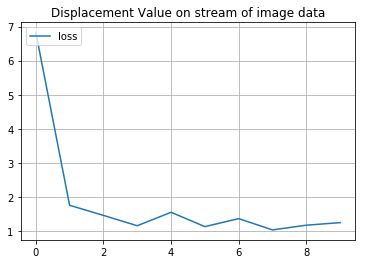

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 13 15:20:36 2020

@author: HPP
"""
import gym
import pandas as pd 
import numpy as np
#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
#from smt.surrogate_models import RBF
from CNN import cnn

csvfile = "Pendulum-v0_dummy.csv"  #file name
neuralnet=cnn(csvfile)
neuralnet.train(1)



In [19]:
def test(sim_steps):
 pend_gym= []
 pend_sm=[]
 obs_old=np.zeros(3,)
 for _ in range(sim_steps):
    env.render()
    #select a random action in range of permissible action (+2 to -2)
    action=env.action_space.sample()
    action=action.astype('double')
    #print("type of action:",type(action))
    obs,reward,done,_=env.step(action) # take a random action and observe the state of system 
    y_predict = neuralnet.predict(np.concatenate((action,obs_old),axis=0))
    pend_gym.append(obs)
    pend_sm.append(y_predict)
    obs_old=obs
    
 df_gym=pd.DataFrame(pend_gym,columns=['cos','sin','theta_dot'])
 df_sm=pd.DataFrame(pend_sm,columns=['cos','sin','theta_dot'])
 df_sm['cos']=(df_sm['cos']*2)-1
 df_sm['sin']=(df_sm['sin']*2)-1
 df_sm['theta_dot']=(df_sm['theta_dot']*16)-8

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["theta_dot"],label='from gym')
 plt.plot(df_sm["theta_dot"],label='from sm')
 plt.grid()
 plt.title('Displacement Value on stream of image data')
 plt.xlabel('image_frame_number')
 plt.ylabel('Disp Value')
 plt.legend(loc="upper left")
 plt.show()

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["cos"],label='from gym')
 plt.plot(df_sm["cos"],label='from sm')
 plt.grid()
 plt.title('Displacement Value on stream of image data')
 plt.xlabel('image_frame_number')
 plt.ylabel('Disp Value')
 plt.legend(loc="upper left")
 plt.show()

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["sin"],label='from gym')
 plt.plot(df_sm["sin"],label='from sm')
 plt.grid()
 plt.title('Displacement Value on stream of image data')
 plt.xlabel('image_frame_number')
 plt.ylabel('Disp Value')
 plt.legend(loc="upper left")
 plt.show()


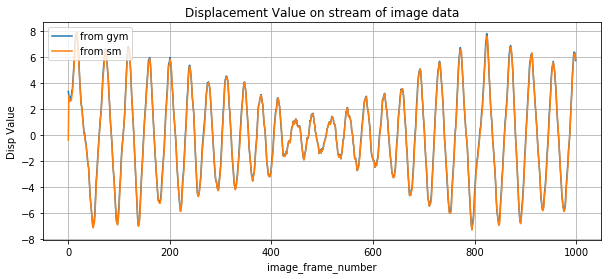

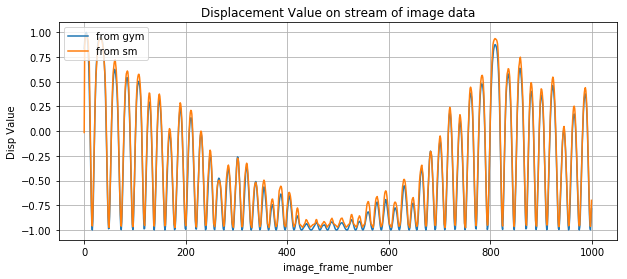

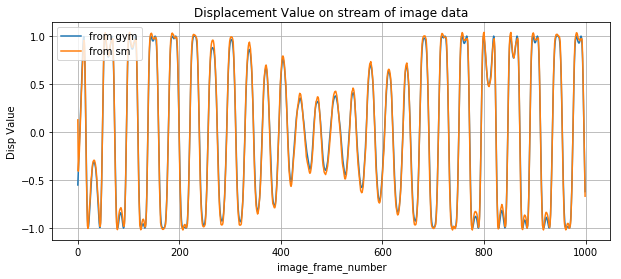

In [22]:
test(1000)

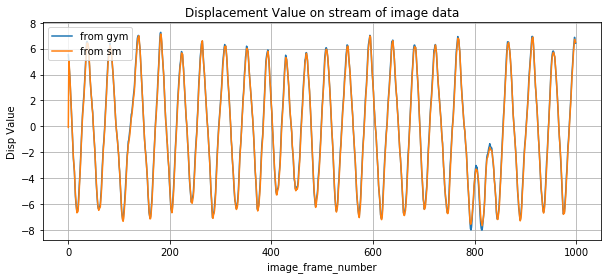

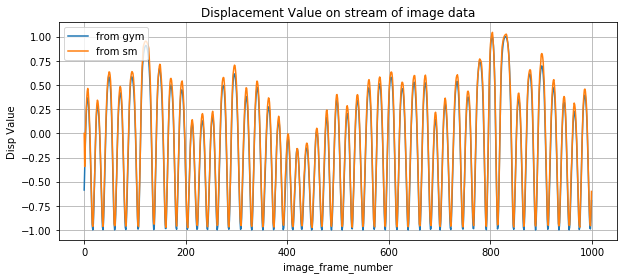

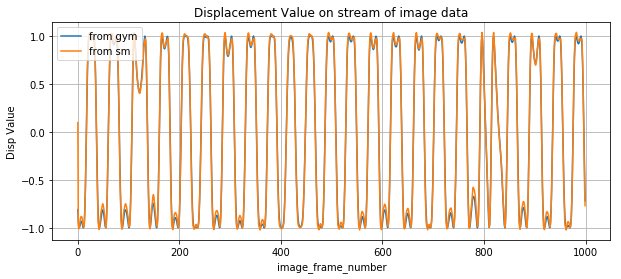

In [23]:
test(1000)